# 1. Data exploration and feature extraction
## Loading Images
Load the images from the three sets (train, validation, and test). 
In this first task of the project, you will explore the Swissroads dataset and extract a set of high-level features for each image in it. To achieve this, you can use the [MobileNet v2](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5) pretrained ConvNet which extracts 1280 high-level features. 
Since the images will be fed to a pretrained model for feature extraction, make sure to set the scale of the pixels and the image size as expected by the model (you can check the expected scale and size in the official [documentation](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5) page)

In [1]:
from zipfile import ZipFile
from keras.preprocessing.image import ImageDataGenerator

from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')

In documentation of imagenet/mobilenet_v2_100_224/feature_vector, we find these requirement for image to feed as input layer.

*This TF Hub model uses the TF-Slim implementation of mobilenet_v2 with a depth multiplier of 1.0 and an input size of 224x224 pixels.*

We will resize using flow_from_directory parameter target_size.

In [2]:
# Define image properties needed for transfer learning
img_width, img_height = 224, 224

In [3]:
# Define file path
zip_path = "swissroads.zip"

# Extract from archive
with ZipFile(zip_path, 'r') as zip:
    zip.extractall()

# Create image generator for training with image transformation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

Here we apply slight range of random transformations, with a rotation_range and zoom_range. Images can be slightly modified during training phase and this should help model better perform on unseen data, validation and test datasets. Same logic for Horizontal flip. 

We use default value for batchsize, which is 32.

In [4]:
train_set = train_datagen.flow_from_directory(
    'train',
    target_size=(img_width, img_height),
    shuffle=True,
    class_mode='sparse'
)

# Create image generators for validation and testing
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_set = valid_datagen.flow_from_directory(
    'valid',
    target_size=(img_width, img_height),
    shuffle=False,
    class_mode='sparse'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    'test',
    target_size=(img_width, img_height),
    shuffle=False,
    class_mode='sparse'
)

Found 281 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 55 images belonging to 6 classes.


Comments on the value types returned by flow_from_directory() method.
* train_set.class_indices returns a dictionnary
* train_set is a `keras.preprocessing.image.DirectoryIterator` with specific methods
* train_set[i] is a tuple
* class_mode 'sparse' returns integer for labels, instead of one hot encoded array with 'categorical'

In [5]:
# Convert to lists keys and values of dictionnary 
class_names = list(train_set.class_indices.keys())
class_labels = list(train_set.class_indices.values())

train_set.class_indices

{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}

## Plotting images
Plot a few images from each category : bike, car, motorcycle, other, truck, van.

Since we have generated batches of 32 (default value) for train_set using shuffle=True, we first make sure we have all categories present in batch that we will use for plotting.

In [6]:
while True:
    # Get a batch of data
    batch = train_set.next()
    images, labels = batch
    # Check that max of numpy array is 5
    if max(labels) == 5:
        # All categories are represented, so use this batch
        break

We plot images, note that this are images where some slight transformation has been applied and they have been resized to 224 x 224 pixels

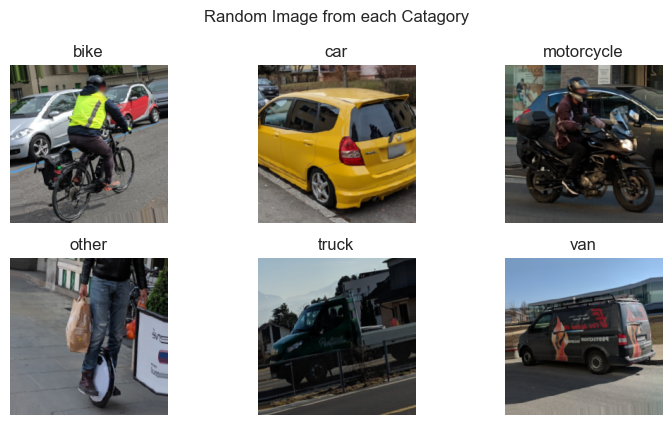

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4))
axes = axes.flatten()

for i, class_label in enumerate(class_labels):
    # Filter images in batch to current category
    class_images = images[labels == class_label]
    
    ax = axes[i]
    ax.imshow(class_images[0])
    ax.axis('off')
    ax.set_title(class_names[i])

plt.tight_layout()
plt.suptitle("Random Image from each Catagory", y=1.05)
plt.show()

## Category visualization
Use an appropriate visualization to show the proportions of each category in the three sets (train, validation, and test). We redefine dictionnary from class_indices.

In [8]:
class_indices = train_set.class_indices
class_indices

{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}

Plotting each histogram as a subplot to compare easily shares side to side. Since we use sparse mode, data_set.classes is a array of values between 0 and 5, representing the 6 categories for each dataset

In [9]:
# Example from valid_set
valid_set.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5])

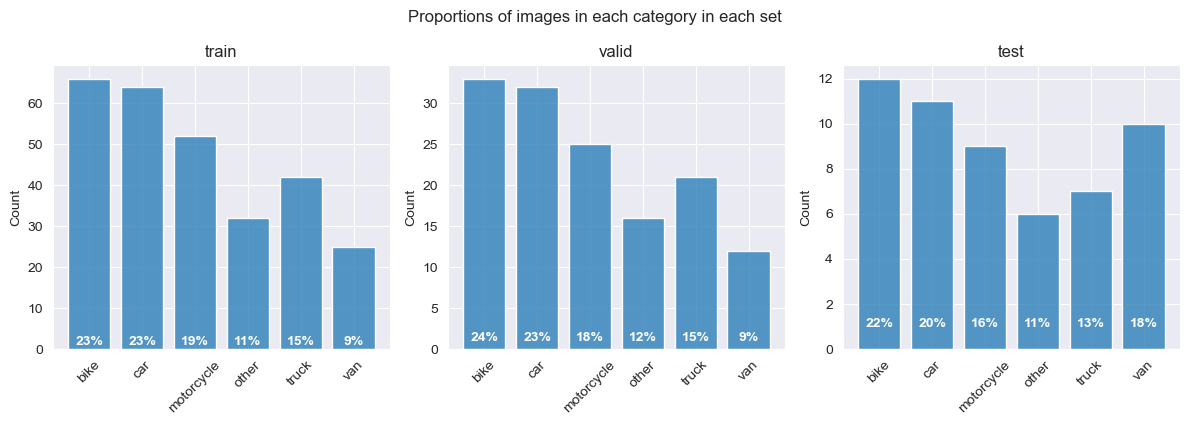

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i, data_set in enumerate([train_set, valid_set, test_set]):
    
    # Calculation of the share per category
    counts = [sum(data_set.classes == class_label) for class_label in class_indices.values()]
    share = [count / sum(counts) * 100 for count in counts]
    
    # Add to histogram count of each category
    ax = sns.histplot(data_set.classes, discrete=True, shrink=0.8, ax=axs[i])
    
    # Add x_ticks with category name
    ax.set_xticks([i for i in range(len(class_indices))])
    ax.set_xticklabels(class_indices.keys(), rotation=45)
    ax.set_title(data_set.directory)
    
    # Add share as label
    for j, share_val in enumerate(share):
        ax.text(j, 1, f'{share_val:.0f}%', ha='center', fontsize=10, fontweight='bold', color='white')


plt.tight_layout()
plt.suptitle("Proportions of images in each category in each set", y=1.05)
plt.show()

As expected share of category is very similar accross all three datasets. 

## Color Histograms
For each of the 6 categories in the training dataset, plot the color histogram.

First, we concatenate all batch of train_set. We don't use train_set.classes as we need labels and images in same order.

In [11]:
images = []
labels = []
for i in range(len(train_set)):
    batch = train_set.next()
    images.append(batch[0])
    labels.append(batch[1])
images = np.concatenate(images)
labels = np.concatenate(labels)

In [12]:
images.shape

(281, 224, 224, 3)

As expected, images is the concatenated array of all images in all batches, each images is 224x224 pixels with 3 channels for each color. 

To select values for each channel, we will use to RGB indexing with flattten(). For instance, `images[:, :, :, 0].flatten()` selects the values for the red color channel, and then flattens those values into a one-dimensional array. This is this one-dimensional array that we plot on histogram. We do the same operation for each channel, plotting each one-dimensional array on top of each other.

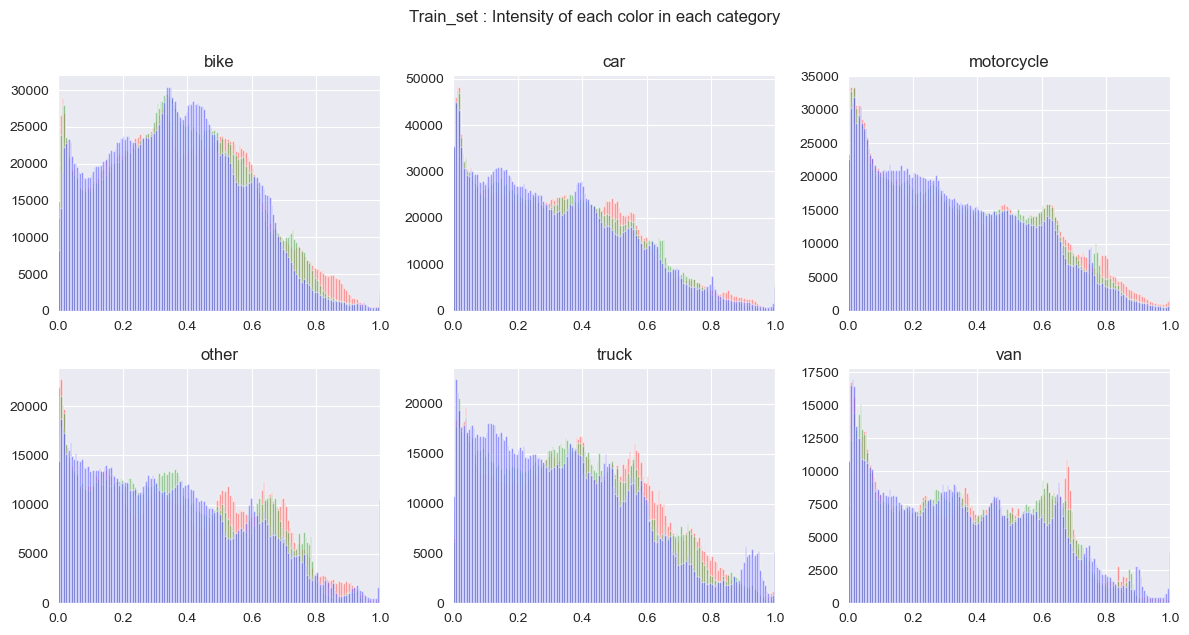

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, class_label in enumerate(class_labels):
    # Filter images to only images in current category
    class_images = images[labels == i]
    
    # Transform each RGB channel into one-dimensionnal array
    r_values = class_images[:, :, :, 0].flatten()
    g_values = class_images[:, :, :, 1].flatten()
    b_values = class_images[:, :, :, 2].flatten()
    
    # Plot histogram on the same subplots
    axes[i].hist(r_values, color='red', alpha=0.5, bins=200, range=(0, 1))
    axes[i].hist(g_values, color='green', alpha=0.5, bins=200, range=(0, 1))
    axes[i].hist(b_values, color='blue', alpha=0.5, bins=200, range=(0, 1))
        
    axes[i].set_title(class_names[i])
    axes[i].set_xlim(0, 1)
    
plt.tight_layout()
plt.suptitle("Train_set : Intensity of each color in each category", y=1.05)

plt.show()

The color proportions are not the same in each category, but do not look sufficient to recognize categories. Example `other`, `van`, `car` have similar RGB histograms. One would infer that anyway the color in the images are made of much more than the vehicle (example of a bike that would have difficulties to make more than 50% of picture).

## High-level features extraction
Extract the high-level features for all the images in the three datasets using MobileNet v2.

### Transfer learning

We import model from tensorflow_hub

In [14]:
import tensorflow as tf
import tensorflow_hub as hub

# Load pre-trained MobileNetV2 feature extractor from TensorFlow Hub
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
feature_extractor = hub.KerasLayer(model_url, input_shape=(224, 224, 3), trainable=False)

We define a function to extract features for a given data set obtained from flow_from_directory. We iterate over batches present within generator not to overload kernel.

In [15]:
def extract_features_from_data_set(data_set):
    """
    Extract features and labels from a given data set using pre-trained MobileNetV2 model from TensorFlow Hub.
    Model has to be loaded beforehand

    Parameters:
    - data_set: A TensorFlow data set object that yields a tuple of images and labels.

    Returns:
    - features: A numpy array of features extracted from the input images.
    - images: A numpy array for the input images.
    - labels: A numpy array of corresponding labels for the input images.    
    """    
    
    features = []
    labels = []
    images = []

    # Iterate over data_set batches
    for i in range(len(data_set)):
        # Get image_batch and label_batch from tuple 
        image_batch, label_batch = data_set[i]
        feature_batch = feature_extractor(image_batch)
        features.append(feature_batch)
        images.append(image_batch)
        labels.append(label_batch)

    # Concatenate all batches into a single array
    features = np.concatenate(features)
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    print(f"Shape of features array: {np.shape(features)}")
    print(f"Shape of labels array: {np.shape(labels)}")

    return features, images, labels

We now run our custom function on each data_set

In [16]:
# Extract features from train set
train_features, train_images, train_labels = extract_features_from_data_set(train_set)

Shape of features array: (281, 1280)
Shape of labels array: (281,)


In [17]:
valid_features, valid_images, valid_labels = extract_features_from_data_set(valid_set)

Shape of features array: (139, 1280)
Shape of labels array: (139,)


In [18]:
test_features, test_images, test_labels = extract_features_from_data_set(test_set)

Shape of features array: (55, 1280)
Shape of labels array: (55,)


Arrays are of expected sizes

### Saving as npz

In [19]:
np.savez_compressed('train_features.npz', features=train_features, images=train_images, labels=train_labels)
np.savez_compressed('test_features.npz', features=test_features, images=test_images, labels=test_labels)
np.savez_compressed('valid_features.npz', features=valid_features, images=valid_images, labels=valid_labels)

We could work with train_features as they are already numpy array, but we prefer at this stage to test reloading of .npz and start working with more commonly named array for test, valid and train. We will reuse this code in other notebooks anyway.

In [20]:
with np.load('train_features.npz') as train_data:
    train_features = train_data['features']
    train_labels = train_data['labels']

X_train = np.array(train_features)
y_train = np.array(train_labels)

In [21]:
with np.load('valid_features.npz') as valid_data:
    valid_features = valid_data['features']
    valid_labels = valid_data['labels']

X_valid = np.array(valid_features)
y_valid = np.array(valid_labels)

In [22]:
with np.load('test_features.npz') as test_data:
    test_features = test_data['features']
    test_labels = test_data['labels']

X_test = np.array(test_features)
y_test = np.array(test_labels)

## Intensity Heatmap
For each of the 6 categories in the training dataset, use a heatmap to visualize the intensity of the 1280 features for all the samples belonging to a specific category. Comment on your findings.

### High-level features behavior by category
Do the high-level features behave the same across the different categories? We first push numpy array to a new dataframe called df_train for easier manipulation with plots.

In [23]:
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train, columns=['target'])

df_train = pd.concat([X_train_df, y_train_df], axis=1)

df_train.shape

(281, 1281)

In [24]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,target
0,0.556302,0.197670,0.000000,0.000000,0.000000,0.000000,0.181899,0.000000,0.000000,0.000000,...,0.127720,0.0,0.000000,0.506676,0.194555,0.000000,0.000000,0.516428,0.076911,1.0
1,0.204151,0.114395,0.008079,0.004778,0.055791,1.234465,0.206456,0.000000,0.000000,0.000000,...,1.198059,0.0,0.047644,0.036382,0.010896,1.456090,0.055297,0.000000,2.020486,0.0
2,0.055899,0.080877,0.017389,0.000000,0.566110,0.183017,0.044299,0.024831,0.033923,0.000000,...,0.000000,0.0,0.507508,0.184023,0.003192,0.350283,0.076034,2.352074,0.000000,1.0
3,0.811386,0.000000,0.194676,0.000000,0.514232,0.319827,0.200115,0.064273,0.323264,0.011812,...,0.000000,0.0,0.614348,0.000000,1.567014,0.000000,0.061297,1.276252,0.777751,1.0
4,1.975352,0.387688,0.059122,0.448419,0.363954,1.324787,0.001842,0.104922,0.517491,0.000000,...,0.120559,0.0,0.222816,0.143729,0.372217,0.127426,0.196280,1.097589,1.136600,1.0


We reuse the lists class_labels [0, 1, 2, 3, 4, 5] and class_names ['bike', 'car', 'motorcycle', 'other', 'truck', 'van'] in interation.

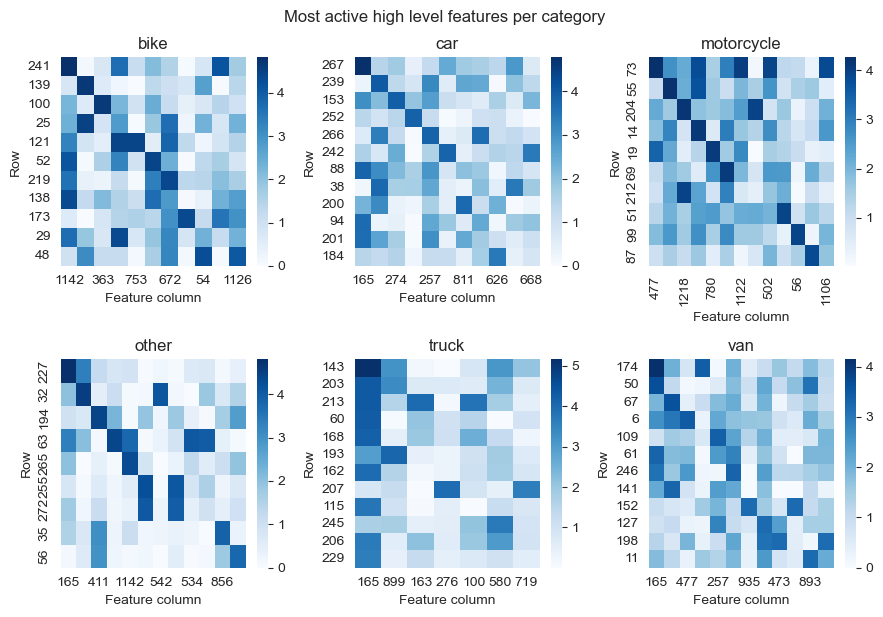

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
axes = axes.flatten()

for i, label in enumerate(class_labels):
    
    # Restrict df_train on a specific category
    df_filtered = df_train[df_train['target'] == label].drop('target', axis=1)
    
    # Obtain the rows and columns numbers for top 15 features values
    stacked_df = df_filtered.stack()
    top_15_indices = stacked_df.nlargest(15, keep='all').index
    top_15_rows = top_15_indices.get_level_values(0).unique()
    top_15_cols = top_15_indices.get_level_values(1).unique()

    # Keep only top values
    df_filtered = df_filtered.loc[top_15_rows, top_15_cols]
    
    sns.heatmap(
        df_filtered, 
        cmap='Blues', 
        ax=axes[i]
    )
    
    axes[i].set_title(class_names[i])    
    axes[i].set_xlabel('Feature column')
    axes[i].set_ylabel('Row')

plt.tight_layout()
plt.suptitle("Most active high level features per category", y=1.02)

plt.show()

High level feature dont behave similarly from category to category. The truck category is a good example of that where a lot of maximal values are present on feature 165, similary to van in that regards. Others wise there is no visual similarities between heatmaps.

## Means

### Features with highest Mean
What are the top 5 features that have the highest mean value? We use the same logic of boolean masking on df_train to filter it in loop to each category..

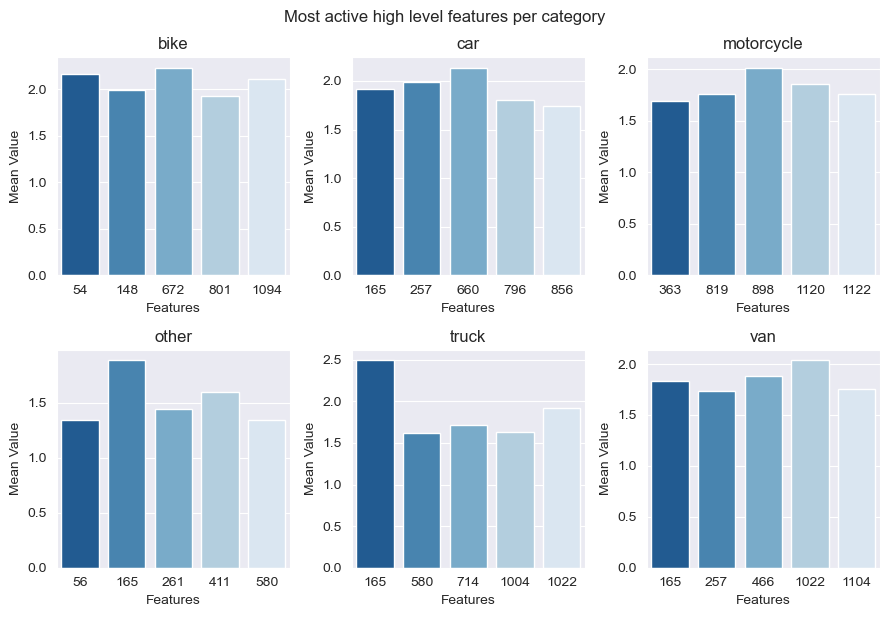

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
axes = axes.flatten()

for i, label in enumerate(class_labels):
    
    # Restrict df_train on a specific category
    df_filtered = df_train[df_train['target'] == label].drop('target', axis=1)
    
    # Keep only top 5 features with highest mean values
    top_5_features = df_filtered.mean().nlargest(5)
    
    sns.barplot(
        x=top_5_features.index,
        y=top_5_features.values,
        ax=axes[i],
        palette='Blues_r'
    )    
    
    axes[i].set_title(class_names[i])   
    axes[i].set_xlabel('Features')
    axes[i].set_ylabel('Mean Value')


plt.tight_layout()
plt.suptitle("Most active high level features per category", y=1.02)
plt.show()


We can observe that the majority of most active high level features are not shared by category, except some as feature 165 present in car/other/truck/van and 1022 present in truck and van.

There is no shocking disparity in how active high level features are from category to category.

### Categories with highest Mean
Which categories share the same most active feature (i.e. have highest means) ? We will insert into a new dataframe the mean values of each feature for each category 

In [27]:
mean_df = pd.DataFrame()

for label in class_labels:
    df_filtered = df_train[df_train['target'] == label].drop('target', axis=1)
    label_mean = df_filtered.mean()
    mean_df[label] = label_mean

# This column indicates which category has the highest mean for a given feature/row
mean_df['highest_mean_label'] = mean_df.idxmax(axis=1)

print(mean_df)

             0         1         2         3         4         5  \
0     0.432532  0.944566  0.581190  0.314120  0.146918  0.232346   
1     0.449363  0.243691  0.470265  0.408286  0.216901  0.091406   
2     0.350375  0.133179  0.347356  0.554291  0.494197  0.158656   
3     0.122838  0.035426  0.124756  0.134685  0.175091  0.020041   
4     1.165453  0.270124  0.139202  0.501186  0.334279  0.499169   
...        ...       ...       ...       ...       ...       ...   
1275  0.083875  0.382524  0.078346  0.160662  0.065696  0.111223   
1276  0.682281  0.117598  0.916839  0.591697  0.147023  0.138002   
1277  0.082256  0.191473  0.062355  0.133993  0.205672  0.118152   
1278  0.013179  0.833000  0.071017  0.174782  0.598799  0.424189   
1279  1.015254  0.161260  0.269444  0.256802  0.298362  0.066492   

      highest_mean_label  
0                      1  
1                      2  
2                      3  
3                      4  
4                      0  
...                  

In [28]:
mean_df['highest_mean_label'].value_counts().sort_values(ascending=False)

2    258
0    253
3    242
1    208
4    167
5    152
Name: highest_mean_label, dtype: int64

In [29]:
class_names

['bike', 'car', 'motorcycle', 'other', 'truck', 'van']

In [30]:
mean_df['highest_mean_label'].value_counts(normalize=True).sort_values(ascending=False)

2    0.201563
0    0.197656
3    0.189062
1    0.162500
4    0.130469
5    0.118750
Name: highest_mean_label, dtype: float64

This means higehst means are present on classes `bike` and `other` with respectively 21.17% and 19.60% of the highest mean values.

## Baseline model

We build a baseline classifier model using `DummyClassifier` class from scikit-learn to build a baseline model with the "most frequent" strategy. We calculate accuracies of baseline model training and test data, and this will help us to compare against performance of later models.

In [31]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Build and fit model
baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X_train, y_train)

# Training accuracy
y_train_pred = baseline_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Test accuracy
y_test_pred = baseline_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)

Training accuracy:  0.23487544483985764
Test accuracy:  0.21818181818181817
